# Simulations for NJ4 single-strain model

In [20]:
from cobra.io import read_sbml_model

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")

### Additional constraints:

Note: a bug in cobrapy means that bounds are overwritten when calling an imported function unless the model is written to file? I think? Be careful about calling functions from scripts in util if they chnage bounds without writing the model to file...

In [21]:
# define the Specific Proton Flux (SPF) property

h_membrane_rx = [r.id for r in nj4.metabolites.h_e.reactions if "EX" not in r.id]

neg_stoich = []
pos_stoich = []

for rx in h_membrane_rx:
    stociometry = {met.id:coeff for met, coeff in nj4.reactions.get_by_id(rx).metabolites.items()}    
    if stociometry["h_e"] < 0:
        pos_stoich.append(rx)
    elif stociometry["h_e"] > 0:
        neg_stoich.append(rx)

# as a constraint
SPF_constraint = nj4.problem.Constraint(
        sum([nj4.reactions.get_by_id(rx).flux_expression for rx in pos_stoich]) - sum([nj4.reactions.get_by_id(rx).flux_expression for rx in neg_stoich]),
        lb=0,
        ub=5)

# as an objective
SPF_obj = nj4.problem.Objective(
        sum([nj4.reactions.get_by_id(rx).flux_expression for rx in pos_stoich]) - sum([nj4.reactions.get_by_id(rx).flux_expression for rx in neg_stoich]),
        direction="max")

In [22]:
nj4_acido = nj4.copy()
nj4_solvento = nj4.copy()

In [23]:
# restrict reaction reversibility

reactions = ["ACACT1r", "HACD1", "ECOAH1", "ACOAD1fr", "ACOAD1", "BTCOARx", "PBUTT", 
             "ADCi", "PTAr", "POR_syn", "FNOR", "FNRR","T2ECR", "BNOCA", #ABE pathway
             ]

reverse_reactions = ["ALCD4", "BUTKr", "BUTCT2", "ACKr", "ACACCT", "ACALD",
                      "HYDA", "HACD1i", "ACOAD1fr", "ACOAD1f", #ABE pathway
                      ]

KO_rx = ["XYLANabc", "GLCURS1"] #xylan uptake reactions

for rx in reactions:
    nj4_acido.reactions.get_by_id(rx).bounds = (0, 1000)
    nj4_solvento.reactions.get_by_id(rx).bounds = (0, 1000)

for rx in reverse_reactions:
    nj4_acido.reactions.get_by_id(rx).bounds = (-1000, 0)
    nj4_solvento.reactions.get_by_id(rx).bounds = (-1000, 0)

for rx in KO_rx:
    nj4_acido.reactions.get_by_id(rx).bounds = (0, 0)
    nj4_solvento.reactions.get_by_id(rx).bounds = (0, 0)

# TCA cycle
nj4_acido.reactions.SUCD2.bounds = (-1000, 1000)

# "closing off" reductive TCA for solventogenesis
nj4_solvento.reactions.SUCD2.bounds = (-1000, 0)
nj4_solvento.reactions.MDH.bounds = (-1000, 0)
# nj4_solvento.reactions.FUM.bounds = (-1000, 0)
    
# # knock out reactions for acetate and butyrate production
nj4_solvento.reactions.ACtr.bounds = (0, 1000)
nj4_solvento.reactions.BUTt.bounds = (0, 1000)

In [24]:
from utils.flux_coupling import add_ratio_constraint_cobra

# flux coupling but/ac production for acidogeneis to exp. value
add_ratio_constraint_cobra(nj4_acido, "BUTt" , "ACtr",  1.02, r_num_reverse=True, r_den_reverse=True)

# flux coupling btoh/acetone production for solventogenesis to exp. value
add_ratio_constraint_cobra(nj4_solvento, "BTOHt" , "ACEt",  2.68, r_num_reverse=True, r_den_reverse=False)

Metabolite identifier,ratio_BTOHt_ACEt
Name,
Memory address,0x130fc3460
Formula,None
Compartment,pseudo
In 2 reaction(s),"BTOHt, ACEt"


In [25]:
# add SPF objectove to solventogen model
nj4_solvento.objective = SPF_obj

In [6]:
# add SPF constraint to solventogen model
#nj4_solvento.add_cons_vars(SPF_constraint)

#### "archive"

In [25]:
# from utils.flux_coupling import add_ratio_constraint_cobra

# # ratio constraints for co2 conversion and export

# add_ratio_constraint_cobra(nj4_acido, "HCO3E" , "CO2t",  5, r_num_reverse=False, r_den_reverse=True)
# add_ratio_constraint_cobra(nj4_solvento, "HCO3E" , "CO2t",  5, r_num_reverse=False, r_den_reverse=True)

Metabolite identifier,ratio_HCO3E_CO2t
Name,
Memory address,0x1326aca90
Formula,None
Compartment,pseudo
In 2 reaction(s),"HCO3E, CO2t"


In [51]:
# flux coupling for acetate and butyrate yields - for acidogenic phase

from utils.flux_coupling import add_ratio_constraint_cobra

# xylose_transport_KO = ["XYLtex", "XYLabc", "XYLt2"]

# for rx in xylose_transport_KO:
#     nj4_acido.reactions.get_by_id(rx).bounds = (0, 0)

# add_ratio_constraint_cobra(nj4_acido, "BUTt" , "XYLt",  0.166, r_num_reverse=False, r_den_reverse=True)
# add_ratio_constraint_cobra(nj4_acido, "ACtr" , "XYLt",  0.162, r_num_reverse=False, r_den_reverse=True)
add_ratio_constraint_cobra(nj4_acido, "BUTt" , "ACtr",  1.02, r_num_reverse=True, r_den_reverse=True)

Metabolite identifier,ratio_BUTt_ACtr
Name,
Memory address,0x1363add50
Formula,None
Compartment,pseudo
In 2 reaction(s),"BUTt, ACtr"


In [52]:
# constraints for the solventogenic phase

# removing possibility for model to secrete acetate and butyrate - hopefully will lead to some enforced uptake
#nj4_solvento.reactions.ACtr.bounds = (0, 1000)
#nj4_solvento.reactions.BUTt.bounds = (0, 1000)

# ac / but flux uptake flux couplued to adhere to the exp. measurements
#add_ratio_constraint_cobra(nj4_solvento, "BUTt" , "ACtr",  0.42, r_num_reverse=False, r_den_reverse=False)

# # acetone / butanol production flux coupling
add_ratio_constraint_cobra(nj4_solvento, "BTOHt" , "ACEt",  2.68, r_num_reverse=True, r_den_reverse=False)

# TODO: some coupling between acetone production and but/ac uptake? - possibly instead of but/ac coupling?
# add_ratio_constraint_cobra(nj4_solvento, "ACEt" , "BUTt",  1, r_num_reverse=False, r_den_reverse=False)
# add_ratio_constraint_cobra(nj4_solvento, "ACEt" , "ACtr",  1, r_num_reverse=False, r_den_reverse=False)

Metabolite identifier,ratio_BTOHt_ACEt
Name,
Memory address,0x1363ae4a0
Formula,None
Compartment,pseudo
In 2 reaction(s),"ACEt, BTOHt"


In [53]:
# # trying different objective functions for solventogenesis

nj4_solvento.objective = SPF_obj

# # nj4_solvento.add_boundary(nj4_solvento.metabolites.nadh_c, type="deman", reaction_id="DM_nadh_c")
# # nj4_solvento.objective = "DM_nadh_c"

# nj4_solvento.add_boundary(nj4_solvento.metabolites.nadh_c, type="deman", reaction_id="DM_nadh_c")
# nj4_solvento.objective = "ATPM"

## Static modelling

Goal: replicate the distinct phases acidogenesis and solventogenesis

In [7]:
from utils import static_sim

medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10,}, fill_value=0.1)
solvento_medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10, "EX_h_e":10, "EX_but_e": 10, "EX_ac_e": 10}, fill_value=0.1)

production_reactions = [
    'EX_ac_e', # acetate exchange
    'EX_but_e', # butyrate exchange
    'EX_acetone_e', # acetone exchange
    'EX_btoh_e', # butanol exhange
    'EX_etoh_e', # ethanol exchange
]

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [25]:
from cobra.flux_analysis import pfba

with nj4_acido as nj4:
    nj4.medium = medium
    
    summary = nj4.summary()
    solution = nj4.optimize()
    pfba_solution = pfba(nj4)

with nj4_solvento as nj4:
    nj4.medium = solvento_medium
    
    solvento_summary = nj4.summary()
    solvento_solution = nj4.optimize()
    solvento_pfba_solution = pfba(nj4)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [43]:
solvento_summary

Metabolite,Reaction,Flux,C-Number,C-Flux
arg__L_e,EX_arg__L_e,0.1,6,1.04%
asp__L_e,EX_asp__L_e,0.1,4,0.69%
ca2_e,EX_ca2_e,0.001906,0,0.00%
cl_e,EX_cl_e,0.001906,0,0.00%
cobalt2_e,EX_cobalt2_e,3.661E-05,0,0.00%
cu2_e,EX_cu2_e,0.0002596,0,0.00%
cys__L_e,EX_cys__L_e,0.03381,3,0.18%
fe2_e,EX_fe2_e,0.002458,0,0.00%
fe3_e,EX_fe3_e,0.002858,0,0.00%
fol_e,EX_fol_e,0.0002449,19,0.01%


- the models main carbon source is xylose, but is also taking up several amino-acids
- butyrate and acetate are being secreted, which is as expected during the solventogenic phase

In [45]:
from escher import Builder

builder = Builder(map_json='escher_maps/ABE_pretty.json', model=nj4, height=600)
solvento_builder = Builder(map_json='escher_maps/ABE_pretty.json', model=nj4, height=600)

In [20]:
builder.reaction_data = pfba_solution.fluxes
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

In [46]:
solvento_builder.reaction_data = solvento_pfba_solution.fluxes
solvento_builder

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR160tipp': 0.0, '12DGR161tip…

In [52]:
static_sim.read_production_rates(pfba_solution)
static_sim.read_production_rates(solvento_pfba_solution)

Production fluxes:
EX_but_e        5.137939
EX_ac_e         5.037195
EX_etoh_e       0.000000
EX_btoh_e      -0.000000
EX_acetone_e    0.000032
Name: fluxes, dtype: float64
Production fluxes:
EX_but_e       -0.337026
EX_ac_e        -0.102149
EX_etoh_e      -0.000000
EX_btoh_e       0.388739
EX_acetone_e    0.145052
Name: fluxes, dtype: float64


- model behaving as we would expect in solventogenic phase
- however, there are several optimal solutions here

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

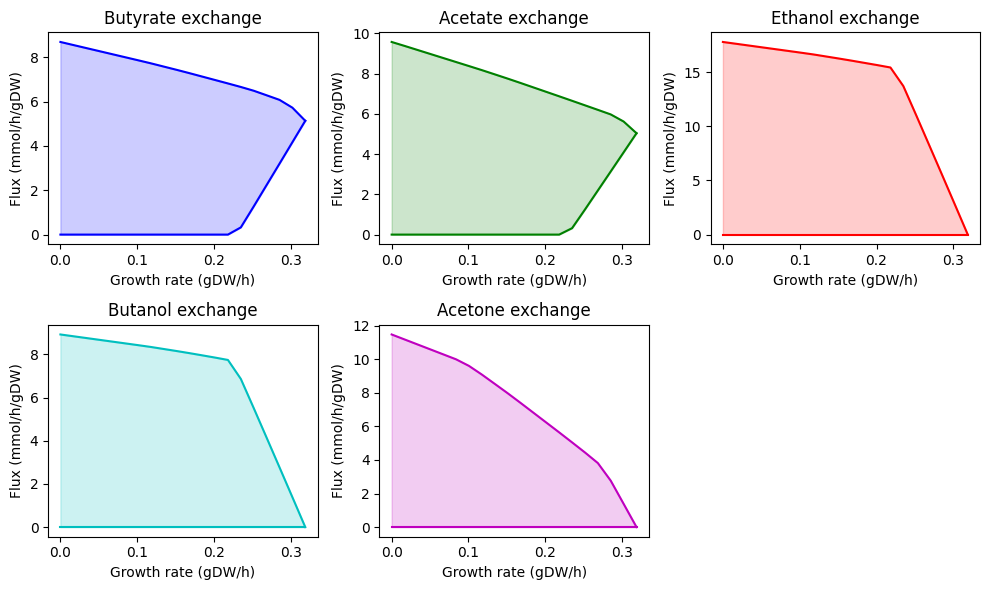

In [10]:
from utils import static_sim

prod_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e", "EX_acetone_e"]

static_sim.plot_flux_envelopes(nj4_acido, medium=medium, reactions=prod_reactions, common_names=True)

# import matplotlib.pyplot as plt
# plt.savefig("figures/nj4_acidogenic.svg", format="svg")

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

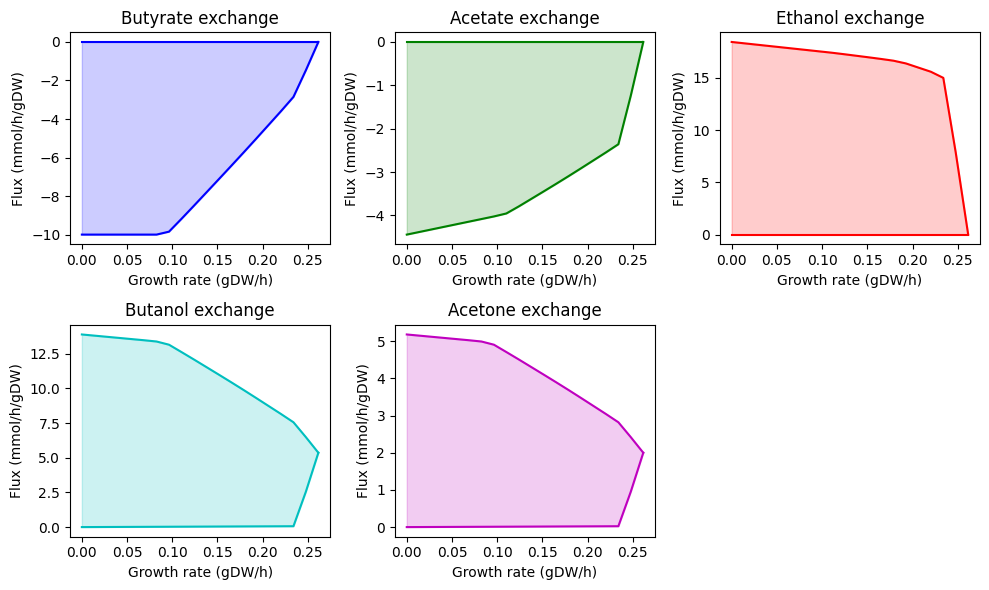

In [19]:
static_sim.plot_flux_envelopes(nj4_solvento, medium=solvento_medium, reactions=prod_reactions, common_names=True)

# import matplotlib.pyplot as plt
# plt.savefig("figures/nj4_solventogenesis.svg", format="svg")

Specific proton flux:

In [19]:
import pandas as pd
from cobra.flux_analysis import pfba

h_membrane_rx = [r.id for r in nj4.metabolites.h_e.reactions if "EX" not in r.id]

neg_stoich = []
pos_stoich = []

for rx in h_membrane_rx:
    stociometry = {met.id:coeff for met, coeff in nj4.reactions.get_by_id(rx).metabolites.items()}    
    if stociometry["h_e"] < 0:
        pos_stoich.append(rx)
    elif stociometry["h_e"] > 0:
        neg_stoich.append(rx)

sols = {}

RANGE = range (-15, 10, 2)

for i in RANGE:
    with nj4_solvento as model:
        
        # add SPF constraint
        SPF_constraint = model.problem.Constraint(
        sum([model.reactions.get_by_id(rx).flux_expression for rx in pos_stoich]) - sum([model.reactions.get_by_id(rx).flux_expression for rx in neg_stoich]),
        lb=i,
        ub=i)

        model.add_cons_vars(SPF_constraint)

        model.medium = solvento_medium

        try:
            sols[i] = pfba(model)
        except:
            print(f"Failed for {i}")
            continue

plot_rx = ["Growth", "EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e", "EX_acetone_e", "EX_h2_e", "EX_co2_e"]

dfs = []

for i in list(sols.keys()):
    df = pd.DataFrame(sols[i][plot_rx])
    df['spf'] = i
    dfs.append(df)

result = pd.concat(dfs)

result["rx"] = result.index

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Failed for -15
Failed for -13
Failed for -11
Failed for -9
Failed for -7


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Failed for 7
Failed for 9


<AxesSubplot: xlabel='spf', ylabel='fluxes'>

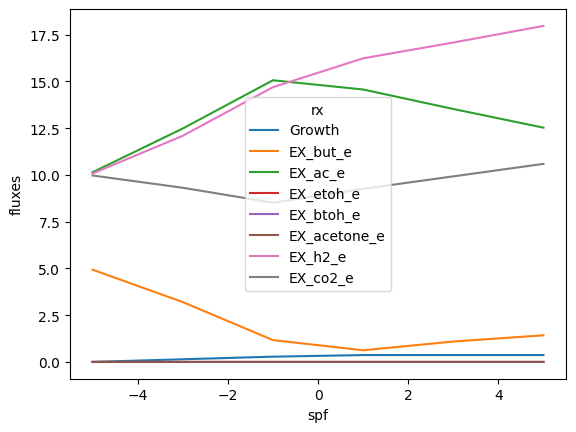

In [20]:
import seaborn as sns

sns.lineplot(data=result, x="spf", y="fluxes", hue="rx")

In [25]:
# calculate specific proton flux for a solution

SPF = 0

for rx in h_membrane_rx:
    stociometry = {met.id:coeff for met, coeff in nj4.reactions.get_by_id(rx).metabolites.items()}    
    SPF += solvento_pfba_solution[rx] * stociometry["h_e"]

note that SPF = EX_h_e if calculations done correctly, so for static sim its a bit moot, but SPF allows constraining also in COMETS sim!

Studying the flux ranges of each reaction:

In [20]:
ABE_REACTIONS = ["POR_syn", "ACACT1r", "HACD1", "ECOAH1", "ACOAD1fr", "ACOAD1", "BTCOARx", "PBUTT", "ADCi", 
                 "PTAr", "ALCD4", "BUTKr", "BUTCT2", "ACKr", "ACACCT", "ACALD", "ACtr", "FNRR", "ALCD2x",
                 "ETOHtrpp", "ETOHtex", "BTOHt", "ACEt", "BUTt"]

ABE_REACTIONS = reactions + reverse_reactions

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


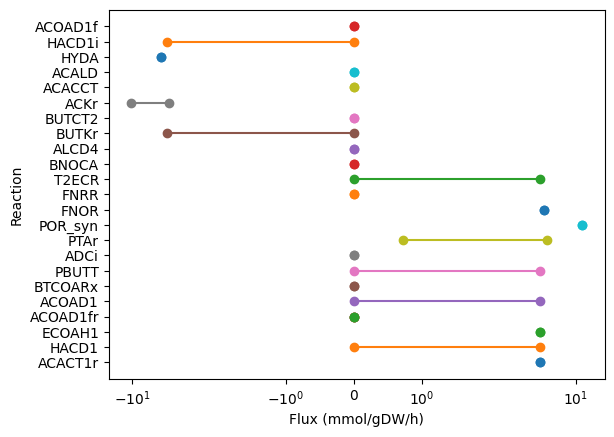

In [21]:
static_sim.plot_flux_ranges(model=nj4_acido, medium=medium, reactions=ABE_REACTIONS)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


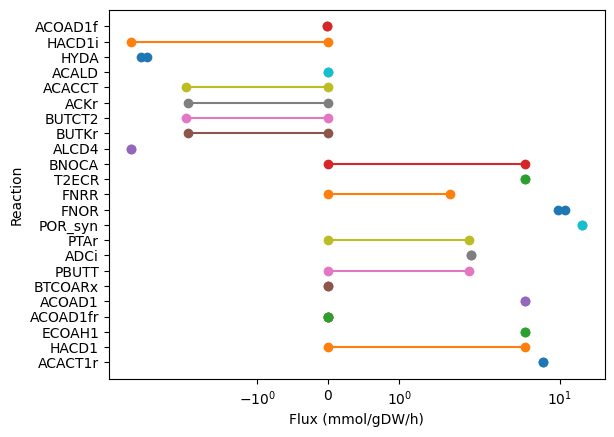

In [22]:
static_sim.plot_flux_ranges(model=nj4_solvento, medium=solvento_medium, reactions=ABE_REACTIONS)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


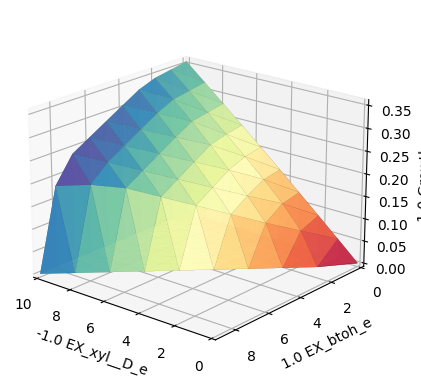

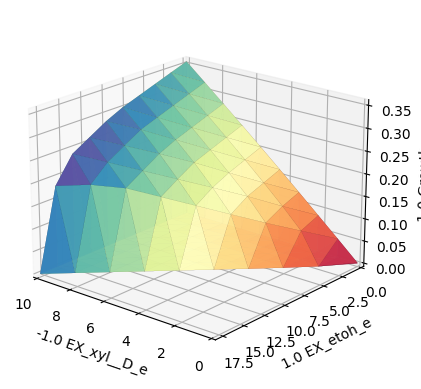

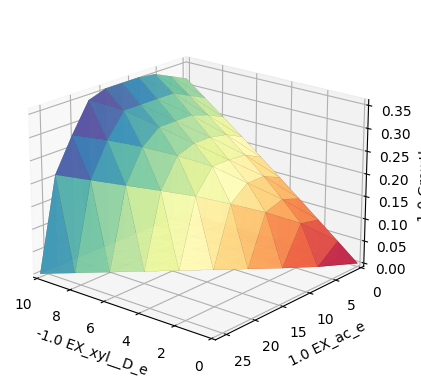

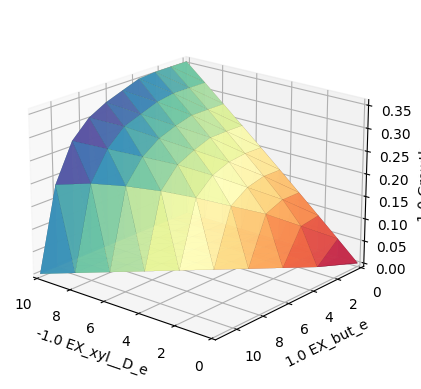

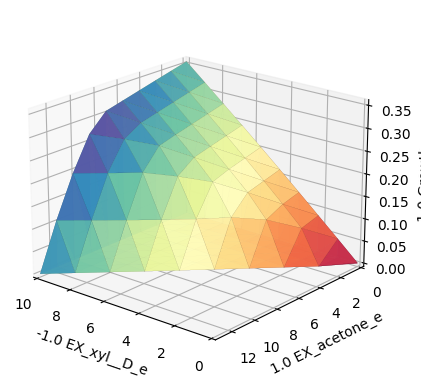

In [18]:
import straindesign as sd
import matplotlib.pyplot as plt

with nj4:
    nj4.medium = medium

    for rx in production_reactions:
        _,_,plot = sd.plot_flux_space(nj4,('-EX_xyl__D_e',rx, 'Growth'),points=10, show=False);
        plot._axes.view_init(elev=20, azim=130)
        plt.show()

## More detailed acidogenic / solventogenic modelling

At standard growth maximisation the model should prefer butyrate / acetate production - since this is the strategy that Clostridium bacteria chose durting exponential growth phase.

Modelling og solventogenic phase as detailed in methods from: [Genome-scale reconstruction and in silico analysis of the Clostridium acetobutylicum ATCC 824 metabolic network](https://doi.org/10.1007/s00253-008-1654-4) (minimal metabolic adjustment from acidogenesis) and [Stoichiometric modeling of Clostridium acetobutylicum fermentations with non-linear constraints](https://doi.org/10.1016/S0168-1656(99)00022-X) (non-liner constraint on acetate and butyrate re-utilisation).

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


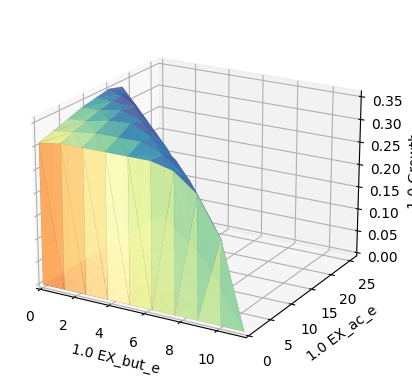

In [23]:
import straindesign as sd
import matplotlib.pyplot as plt
from utils import static_sim

with nj4:
    nj4.medium = medium

    _,_,plot = sd.plot_flux_space(nj4,('EX_but_e','EX_ac_e', 'Growth'),points=10, show=False);
    plot._axes.view_init(elev=20, azim=300)
    plt.show()

We see that the growth is maximised most when there is production of both acetate and butyrate. 

In [24]:
from utils import static_sim

acidogenic_medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10,}, fill_value=0.1)

with nj4:
    nj4.medium = acidogenic_medium
    acidogenic_summary = nj4.summary()
    acidogenic_sol = nj4.optimize()

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


### solventogenic phase

impose constraints on butyrate and acetate uptake like in the article, then solve a MOMA problem from the previous solution like done in the iJL432 paper

use data from CBP paper to find appropriate ac / but constraint?

In [25]:
from utils.flux_coupling import add_ratio_constraint_cobra

add_ratio_constraint_cobra(nj4, "EX_but_e" , "EX_ac_e", 0.315)

Metabolite identifier,ratio_EX_but_e_EX_ac_e
Name,
Memory address,0x124ceead0
Formula,None
Compartment,pseudo
In 2 reaction(s),"EX_ac_e, EX_but_e"


In [30]:
from cobra.flux_analysis import moma

solventogenic_medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10, "EX_but_e": 10, "EX_ac_e": 10, "EX_h_e": 10})

with nj4:
    nj4.medium = solventogenic_medium

    nj4.reactions.EX_but_e.bounds = (-10, 0)
    nj4.reactions.EX_ac_e.bounds = (-10, 0)
    
    # solve a moma problem!
    solventogenic_sol = moma(nj4, solution=acidogenic_sol)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [28]:
import escher
from escher import Builder

builder_acido = Builder(map_json='escher_maps/ABE_pretty.json', model=nj4, height=600)
builder_acido.reaction_data = acidogenic_sol.fluxes
builder_acido

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR160tipp': 0.0, '12DGR161tip…

In [32]:
import escher
from escher import Builder

builder_solvento = Builder(map_json='escher_maps/ABE_pretty.json', model=nj4, height=600)
builder_solvento.reaction_data = solventogenic_sol.fluxes
builder_solvento

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR160tipp': 0.0, '12DGR161tip…

## Dynamic modelling

In [26]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

nj4_med = media_db[media_db["medium"] == "nj4_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in nj4_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}
added_metabilotes["xyl__D_e"] = 20 # 20 mmol corresponds to 60 g/L xylose

In [27]:
from utils.kinetic_params import NJ4_VMAX, NJ4_KM

In [28]:
AA_uptake_rx = ["EX_val__L_e", "EX_arg__L_e", "EX_asp__L_e", "EX_dhptd_e", "EX_glu__L_e", "EX_ile__L_e", "EX_ser__L_e", 
                "EX_thr__L_e", "EX_ala__L_e", "EX_cys__L_e", "EX_gly_e", "EX_his__L_e", "EX_leu__L_e", 
                "EX_met__L_e", "EX_phe__L_e", "EX_pro__L_e", "EX_tyr__L_e", "EX_trp__L_e", "EX_lys__L_e"]


for rx in AA_uptake_rx:
    NJ4_KM[rx] = 1

In [50]:
# km = {"EX_xyl__D_e": 1.2}
# vmax = {"EX_xyl__D_e": 6}

### single model:

In [ ]:
from utils.comets_functions import single_strain

sim = single_strain(model=nj4_acido, medium=added_metabilotes, sim_time=96, km_dict=NJ4_KM, vmax_dict=NJ4_VMAX)

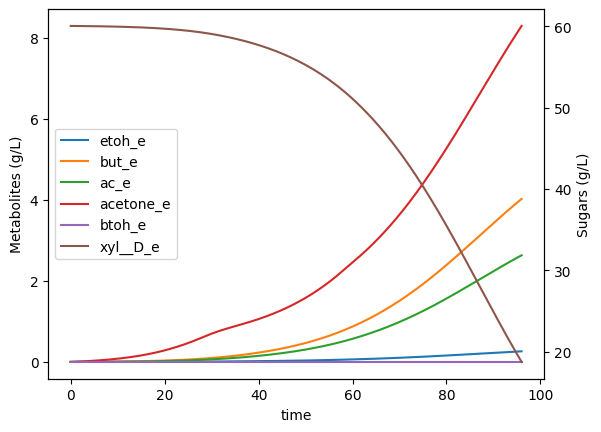

In [9]:
import seaborn as sns
from utils.comets_functions import plot_metabolites, plot_biomass, plot_reaction_flux

metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e", "acetone_e"]

plot_metabolites(sim, metabolites)

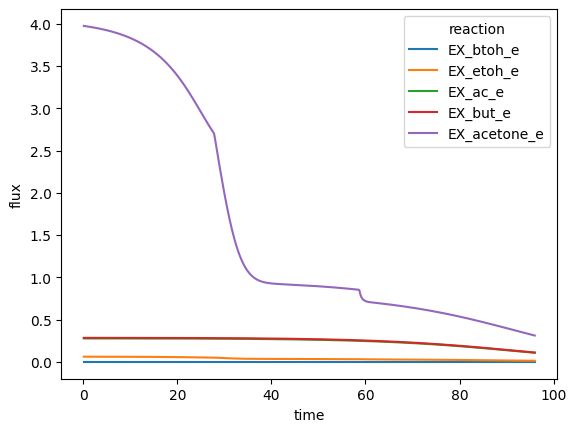

In [149]:
prod_reactions = ['EX_btoh_e', 'EX_etoh_e', 'EX_ac_e', 'EX_but_e', 'EX_acetone_e',]

plot_reaction_flux(sim, prod_reactions, "NJ4")

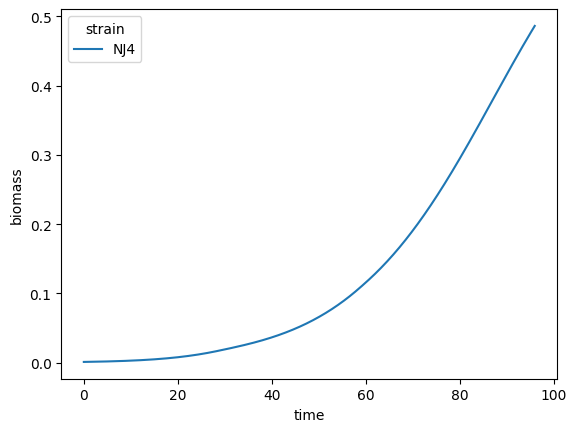

In [150]:
plot_biomass(sim)

### acido/solvento sepperated model:

In [30]:
from utils import comets_functions as cf

acido_sim, solvento_sim = cf.two_phase_sim(nj4_acido, nj4_solvento, medium=added_metabilotes, km_dict=NJ4_KM, vmax_dict=NJ4_VMAX, initial_pop=0.0005)


Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!


In [31]:
bm, met, fluxes = cf.collapse_sequential_sim(acido_sim, solvento_sim, mult_species=False)

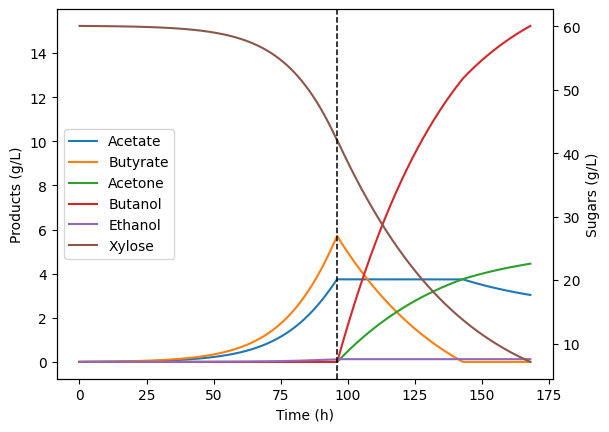

In [33]:
metabolites = ["xyl__D_e", "ac_e", "but_e",  "acetone_e", "btoh_e",  "etoh_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=96, use_molar_amount=False, common_names=True)

# import matplotlib.pyplot as plt
# plt.savefig("figures/nj4.svg", format="svg")

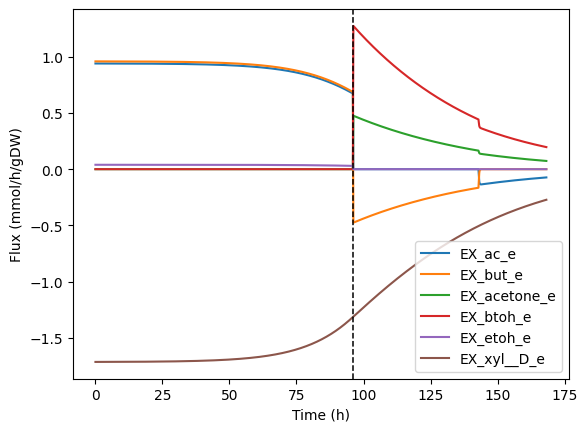

In [34]:
import matplotlib.pyplot as plt

production_reactions = ["EX_ac_e", "EX_but_e", "EX_acetone_e", "EX_btoh_e", "EX_etoh_e", "EX_xyl__D_e"]

cf.plot_reaction_flux(fluxes=fluxes["NJ4"], reactions=production_reactions, inoc_time=96)

#plt.savefig("figures/nj4_flux.svg", format="svg")

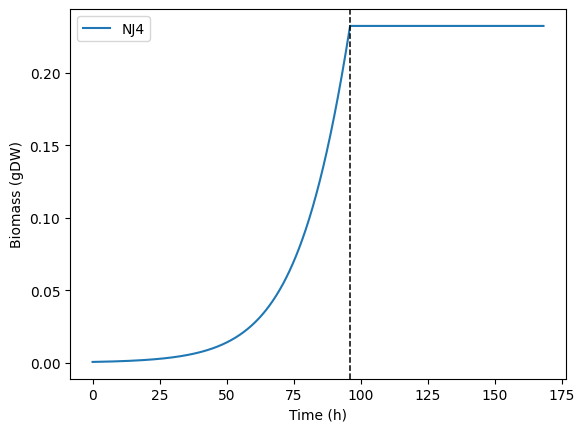

In [35]:
cf.plot_biomass(total_biomass=bm, inoc_time=96)

plt.savefig("figures/nj4_bm.svg", format="svg")

In [43]:
import escher
from escher import Builder

animation = Builder(map_json='escher_maps/ABE_pretty.json', model=nj4, height=600)

In [45]:
from time import sleep
from tqdm.notebook import tqdm

#animate_fluxes = sim.fluxes_by_species["NJ4"].drop(columns=["x", "y"])
animate_fluxes = fluxes["NJ4"].drop(columns=["x", "y"])

melted_fluxes = animate_fluxes.melt(id_vars="cycle", value_name="flux", var_name="reaction")

n_cycles = animate_fluxes.shape[0]

for i in tqdm(range(n_cycles)):
    point_in_time = melted_fluxes[melted_fluxes["cycle"] == i]
    flux_series = point_in_time.set_index("reaction")["flux"]
    animation.reaction_data = flux_series
    sleep(0.01)

  0%|          | 0/1680 [00:00<?, ?it/s]

In [44]:
animation

Builder(height=600)